<a href="https://colab.research.google.com/github/hmin27/2023_DL_Clip/blob/main/CLIP(Finetune)_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Fine tuning
- Food image classification with 4shot dataset
- Hyperparameter Tuning
- Evaluating with Validation set


In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [23]:
import os
import clip
import torch
from torch import nn, optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
import shutil

%matplotlib inline
BATCH_SIZE = 4
EPOCH = 50
LR = 1e-4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Prepare the Model and Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model = model.to(torch.float32)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 67.3MiB/s]


In [6]:
# Creating class name list
import pandas as pd
import os

data_folder = '/content/drive/MyDrive/Study/DL_CLIP/Food_fewshot/4_shot/train'
class_list = []
class_folders = sorted(os.listdir(data_folder))

for class_folder in class_folders:
    class_folder_path = os.path.join(data_folder, class_folder)
    image_files = sorted(os.listdir(class_folder_path))

    # Create text description using class label
    classes = f"{class_folder.replace('_',' ')}"
    class_list.append(classes)


print(class_list)  # 33개

['apple pie', 'baked potato', 'burger', 'butter naan', 'chai', 'chapati', 'cheesecake', 'chicken curry', 'chole bhature', 'crispy chicken', 'dal makhani', 'dhokla', 'donut', 'fried rice', 'fries', 'hot dog', 'ice cream', 'idli', 'jalebi', 'kaathi rolls', 'kadai paneer', 'kulfi', 'masala dosa', 'momos', 'omelette', 'paani puri', 'pakode', 'pav bhaji', 'pizza', 'samosa', 'sandwich', 'sushi', 'taco']


In [7]:
# Few-shot learning

class FewshotDataset(Dataset):
    def __init__(self, data_folder, preprocess):
        self.data_folder = data_folder
        self.preprocess = preprocess
        self.image_paths = []
        self.text_descriptions = []
        self.labels = []

        # image path list, text list
        class_folders = sorted(os.listdir(data_folder))

        for label, class_folder in enumerate(class_folders):
            class_folder_path = os.path.join(data_folder, class_folder)
            image_files = sorted(os.listdir(class_folder_path))

            for image_file in image_files:
                image_path = os.path.join(class_folder_path, image_file)
                self.image_paths.append(image_path)

                text_description = f"a photo of {class_folder.replace('_', ' ')}"
                self.text_descriptions.append(text_description)

                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = self.preprocess(image)
        text = self.text_descriptions[idx]
        label = self.labels[idx]
        return image, text, label


data_folder = '/content/drive/MyDrive/Study/DL_CLIP/Food_fewshot/4_shot'

# Use augmentations in the train dataset
train_dataset = FewshotDataset(os.path.join(data_folder, 'train'), preprocess)
val_dataset = FewshotDataset(os.path.join(data_folder, 'validation'), preprocess)
test_dataset = FewshotDataset(os.path.join(data_folder, 'test'), preprocess)

# Create DataLoader instances
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


print(len(train_dataset))  # 132

132


Image Path: torch.Size([3, 224, 224])
Text Description: a photo of kulfi
4
Label:  tensor([21, 22,  9, 15])
torch.Size([4])
torch.Size([4])


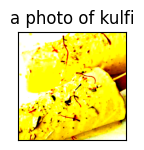

In [8]:
from numpy.lib import shape_base
import matplotlib.pyplot as plt

for batch in trainloader:
    images, texts, labels = batch
    # Print the first batch

    print("Image Path:", images[0].shape)
    print("Text Description:", texts[0])
    print(len(texts))
    print("Label: ", labels)
    print(labels.shape)
    print(torch.unique(labels).shape)


    plt.subplot(2, 4, 2)
    image = images[0].numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.title(f"{texts[0]}")
    plt.xticks([])
    plt.yticks([])

    break

# Loss and Optimizer


In [ ]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(trainloader)*EPOCH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(LR)


#Train and validation

In [ ]:
import matplotlib.pyplot as plt
best_te_loss = 1e5
best_ep = -1

train_losses = []
val_losses = []

for epoch in range(EPOCH):
    print(f"Epoch: {epoch+1}")

    # Training loop
    model.train()
    train_loss = 0
    step = 0
    pbar = tqdm(trainloader, total=len(trainloader))
    for batch in pbar:
        step += 1
        optimizer.zero_grad()

        images, texts, _ = batch
        texts = clip.tokenize(texts).to(device)
        images = images.to(device)

        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        actual_batch_size = images.size(0)
        ground_truth = torch.arange(actual_batch_size).to(device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        train_loss += total_loss.item()

        total_loss.backward()

        if device == "cpu":
            optimizer.step()
        else :
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch+1}/{EPOCH}, Train Loss: {total_loss.item():.4f}", refresh=True)
    train_loss /= step
    train_losses.append(train_loss)


    # Validation loop
    val_loss = 0
    step = 0
    with torch.no_grad():
        model.eval()
        test_pbar = tqdm(valloader, total = len(valloader))
        for batch in test_pbar:
            step += 1
            images, texts, _ = batch
            images = images.to(device)
            texts = clip.tokenize(texts).to(device)

            logits_per_image, logits_per_text = model(images, texts)

            actual_batch_size = logits_per_image.size(0)
            ground_truth = torch.arange(actual_batch_size).to(device)
            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
            val_loss += total_loss.item()

            test_pbar.set_description(f"Epoch {epoch+1}/{EPOCH}, Validation Loss: {total_loss.item():.4f}", refresh=True)
        val_loss /= step
        val_losses.append(val_loss)

    if val_loss < best_te_loss:
        best_te_loss = val_loss
        best_ep = epoch
        torch.save(model.state_dict(), "best_model.pt")

    print(f"epoch {epoch+1}, Train Loss {train_loss}, Validation Loss {val_loss}")

plt.plot(range(1, EPOCH+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCH+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), 'CLIP_4shot_lr5_adam_w.pth')
shutil.copy('CLIP_4shot_lr5_adam_w.pth', '/content/drive/MyDrive/Study/DL_CLIP/model/CLIP_4shot_lr5_adam_w.pth')

'/content/drive/MyDrive/Study/DL_CLIP/model/CLIP_4shot_lr5_adam_w.pth'

In [ ]:
# check the text and label in datatset
num_samples = 10
train_samples = [(val_dataset[i][1], val_dataset[i][2]) for i in range(num_samples)]

for text, label in train_samples:
    print(f"Text: {text}, Label: {label}")


# Evaluate with the Validation set


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

val_correct_top1 = 0
val_correct_top3 = 0
total_val_samples = len(valloader.dataset)

with torch.no_grad():
    for val_batch in valloader:
        val_images, val_texts, val_labels = val_batch
        val_images = val_images.to(device)
        val_texts =  torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_list]).to(device)
        val_labels = val_labels.to(device)

        logits_per_image, _ = model(val_images, val_texts)

        # Top-1 accuracy
        val_top1_pred = logits_per_image.argmax(dim=1)
        val_correct_top1 += (val_top1_pred == val_labels).sum().item()

        # Top-3 accuracy
        _, val_top3_pred = logits_per_image.topk(3, dim=1)
        val_correct_top3 += val_top3_pred.eq(val_labels.view(-1, 1).expand_as(val_top3_pred)).sum().item()

# Calculate accuracy
val_top1_accuracy = val_correct_top1 / total_val_samples
val_top3_accuracy = val_correct_top3 / total_val_samples

print(f"Validation Top-1 Accuracy: {val_top1_accuracy * 100:.2f}%")
print(f"Validation Top-3 Accuracy: {val_top3_accuracy * 100:.2f}%")